<a href="https://colab.research.google.com/github/JurateKubiliene/Python_Code/blob/main/Product_Analyst_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Analyst Project

Your PM would like to see the users' duration from first arriving on the website on any given day until their first purchase on that same day. Your final result should show the duration dynamic daily.

*   Create a presentation centered around the dynamic daily duration.
*   See whether you can apply 1-2 techniques learned in this module course material to enhance your presentation on this subject.
*   Explore the data. See whether there are interesting data points that can give more insights to your presentation.
*   Provide analytical insights, what are the drawbacks of this analysis, what further analysis could you recommend?

# Imports

In [ ]:
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

Import Python libraries

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

Import data

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
from google.cloud import bigquery

project_id = 'tc-da-1'
client = bigquery.Client(project=project_id)

query = '''
SELECT *
FROM `tc-da-1.turing_data_analytics.raw_events`
'''

query_job = client.query(query)

raw_events_df = query_job.to_dataframe()

raw_events_df.head()

,event_date,event_timestamp,event_name,event_value_in_usd,user_id,user_pseudo_id,user_first_touch_timestamp,category,mobile_model_name,mobile_brand_name,...,purchase_revenue_in_usd,refund_value_in_usd,shipping_value_in_usd,tax_value_in_usd,transaction_id,page_title,page_location,source,page_referrer,campaign
0,20201202,1606881541896519,view_item,NaN,None,29317548.3063896358,1606871511419686,desktop,Safari,Apple,...,NaN,NaN,NaN,NaN,(not set),Lifestyle,https://shop.googlemerchandisestore.com/Google...,None,None,None
1,20201114,1605392610344359,view_promotion,NaN,None,4383614.3730633351,1605392601144961,desktop,Safari,Apple,...,NaN,NaN,NaN,NaN,(not set),Home,https://shop.googlemerchandisestore.com/,None,None,None
2,20201107,1604781587987378,page_view,NaN,None,61209114.8357619230,1604781499944546,desktop,Safari,Apple,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/,None,None,None
3,20201208,1607408624997397,session_start,NaN,None,7484797.1571607703,1607408624997397,desktop,Safari,Apple,...,NaN,NaN,NaN,NaN,None,YouTube | Shop by Brand | Google Merchandise S...,https://shop.googlemerchandisestore.com/Google...,None,None,None
4,20201123,1606091693833447,page_view,NaN,None,766583098.5979816085,1603396709216625,desktop,Safari,Apple,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/,None,None,None


# Data filtering and preparation for visualizations

In [6]:
# Change date format from string to datetime
raw_events_df['event_date'] = pd.to_datetime(raw_events_df['event_date'])

# Filter the dataframe to include only rows where event_name is 'purchase' and purchase_revenue_in_usd is 0
zero_revenue_purchases = raw_events_df[(raw_events_df['event_name'] == 'purchase') & (raw_events_df['purchase_revenue_in_usd'] == 0)]

# Check if there are any empty purchase rows
if not zero_revenue_purchases.empty:
    print("There are rows where event_name is 'purchase' but purchase_revenue_in_usd is 0.")
else:
    print("There are no rows where event_name is 'purchase' but purchase_revenue_in_usd is 0.")

There are rows where event_name is 'purchase' but purchase_revenue_in_usd is 0.


In [7]:
# Filter out rows where event_name is 'purchase' but purchase_revenue_in_usd is 0
raw_events_filt = raw_events_df[~((raw_events_df['event_name'] == 'purchase') & (raw_events_df['purchase_revenue_in_usd'] == 0))]

In [8]:
# Filter the DataFrame to include only 'purchase' or 'first_visit' events
filtered_events = raw_events_filt[raw_events_filt['event_name'].isin(['purchase', 'first_visit'])]

# Group the filtered data by 'user_pseudo_id' and 'event_date'
grouped_events = filtered_events.groupby(['user_pseudo_id', 'event_date'])

# Initialize an empty list to store the calculated time differences
time_diffs = []

for (user_id, date), group in grouped_events:
    # Check if both 'purchase' and 'first_visit' events occurred on the same date
    if set(group['event_name']) == {'purchase', 'first_visit'}:
        # Get the first visit timestamp for the user on the date
        first_visit_timestamp = group[group['event_name'] == 'first_visit']['event_timestamp'].min()

        # Get the purchase timestamp for the user on the date
        purchase_timestamp = group[group['event_name'] == 'purchase']['event_timestamp'].min()

        # Calculate the time difference between first visit and purchase timestamps
        time_difference = purchase_timestamp - first_visit_timestamp

        # Append the user ID, event date, and time difference to the list
        time_diffs.append((user_id, date, purchase_timestamp, time_difference))

# Create a DataFrame from the calculated time differences
time_diff_df = pd.DataFrame(time_diffs, columns=['user_pseudo_id', 'event_date', 'purchase_timestamp', 'time_to_purchase_µs'])


In [9]:
# Convert microseconds to minutes
time_diff_df['time_to_purchase_min'] = time_diff_df['time_to_purchase_µs']/60000000
print('The table has ', time_diff_df.shape[0],' rows')
time_diff_df.head()

The table has  1987  rows


,user_pseudo_id,event_date,purchase_timestamp,time_to_purchase_µs,time_to_purchase_min
0,10092926.3786306416,2021-01-22,1611293856871176,840579390,14.009657
1,10111055.8768683862,2020-12-10,1607603334901943,599183193,9.986387
2,1014825.0200289249,2020-11-03,1604390166881926,678889712,11.314829
3,1016446.8237887674,2020-12-21,1608550417964725,7578325151,126.305419
4,10172849.5375293351,2020-12-09,1607499112105600,1047751147,17.462519


In [10]:
# Add more columns from the original DataFrame
additional_columns = raw_events_df[['user_pseudo_id', 'event_timestamp', 'purchase_revenue_in_usd', 'category', 'browser', 'country']]

# Merge 'time_diff_df' with the additional columns based on user_pseudo_id and purchase_timestamp
merged_df = pd.merge(time_diff_df, additional_columns, how='left', left_on=['user_pseudo_id', 'purchase_timestamp'], right_on=['user_pseudo_id', 'event_timestamp'])

merged_df['revenue_per_min'] = merged_df['purchase_revenue_in_usd']/merged_df['time_to_purchase_min']

# Drop the timestamp columns, as they only served a joining purpose, as well as 'time_to_purchase_µs' column
merged_df.drop(columns=['purchase_timestamp', 'time_to_purchase_µs'], inplace=True)

In [11]:
# Convert UNIX timestamps to datetime objects
merged_df['event_timestamp'] = pd.to_datetime(merged_df['event_timestamp'], unit='us')

# Define time of day categories
categories = {
    'Morning': (6, 12),   # 6:00 AM to 11:59 AM
    'Daytime': (12, 18),  # 12:00 PM to 5:59 PM
    'Evening': (18, 24),  # 6:00 PM to 11:59 PM
    'Night': (0, 6)       # 12:00 AM to 5:59 AM
}

# Function to categorize timestamps
def categorize_time(timestamp):
    hour = timestamp.hour
    for category, (start, end) in categories.items():
        if start <= hour < end:
            return category
    return None

# Apply categorization function to create new column
merged_df['time_of_day'] = merged_df['event_timestamp'].apply(categorize_time)

# Display DataFrame with new column
merged_df

,user_pseudo_id,event_date,time_to_purchase_min,event_timestamp,purchase_revenue_in_usd,category,browser,country,revenue_per_min,time_of_day
0,10092926.3786306416,2021-01-22,14.009657,2021-01-22 05:37:36.871176,90.0,desktop,Chrome,United States,6.424140,Night
1,10111055.8768683862,2020-12-10,9.986387,2020-12-10 12:28:54.901943,94.0,mobile,Chrome,Vietnam,9.412814,Daytime
2,1014825.0200289249,2020-11-03,11.314829,2020-11-03 07:56:06.881926,183.0,mobile,Chrome,United States,16.173466,Morning
3,1016446.8237887674,2020-12-21,126.305419,2020-12-21 11:33:37.964725,86.0,tablet,Chrome,United States,0.680889,Morning
4,10172849.5375293351,2020-12-09,17.462519,2020-12-09 07:31:52.105600,156.0,desktop,Chrome,Sweden,8.933419,Morning
...,...,...,...,...,...,...,...,...,...,...
1982,9692619.6154700763,2020-12-11,30.103955,2020-12-11 06:37:22.224028,77.0,mobile,Safari,United States,2.557803,Morning
1983,97146775.1973953571,2021-01-23,12.173866,2021-01-23 11:02:43.905586,14.0,desktop,Chrome,India,1.150004,Morning
1984,97950097.5837353470,2020-12-09,211.172672,2020-12-09 12:57:48.946273,140.0,mobile,Safari,India,0.662965,Daytime
1985,9963542.3978980993,2020-11-12,10.295098,2020-11-12 21:43:02.956421,82.0,mobile,Safari,Slovenia,7.964956,Evening


In [12]:
# Group by 'time_of_day' and aggregate for visualizations
df_time_of_day = merged_df.groupby('time_of_day').agg({
    'user_pseudo_id': 'nunique',  # Count unique customer IDs
    'purchase_revenue_in_usd': 'sum'
})

df_time_of_day.columns = ['num_customers_bought', 'sales_revenue']

# Reset index to make 'event_date' a column instead of index
df_time_of_day.reset_index(inplace=True)

df_time_of_day['average_sales']=df_time_of_day['sales_revenue']/df_time_of_day['num_customers_bought']
df_time_of_day['average_sales']=df_time_of_day['average_sales'].apply(lambda x: '{:.2f}'.format(x))


df_time_of_day.head()

,time_of_day,num_customers_bought,sales_revenue,average_sales
0,Daytime,492,32015.0,65.07
1,Evening,571,35886.0,62.85
2,Morning,477,31583.0,66.21
3,Night,447,29195.0,65.31


In [13]:
# Group by 'event_date' and aggregate for visualizations
df_for_viz = merged_df.groupby('event_date').agg({
    'user_pseudo_id': 'nunique',  # Count unique customer IDs
    'purchase_revenue_in_usd': 'sum',  # Sum of purchase revenue
    'time_to_purchase_min': ['mean', 'median'] # Avg and median session length before purchase
})

df_for_viz.columns = ['num_customers_bought', 'total_revenue', 'avg_session_length', 'median_session_length']

# Reset index to make 'event_date' a column instead of index
df_for_viz.reset_index(inplace=True)

df_for_viz.head()


,event_date,num_customers_bought,total_revenue,avg_session_length,median_session_length
0,2020-11-01,8,475.0,34.927640,17.867640
1,2020-11-02,15,954.0,87.018423,11.839365
2,2020-11-03,19,1443.0,95.757177,18.404333
3,2020-11-04,6,371.0,67.687721,59.583415
4,2020-11-05,10,706.0,51.752678,22.099345


In [14]:
# Group by 'browser' and 'category' and aggregate for visualizations
browser_df = merged_df.groupby(['browser','category']).agg({
    'user_pseudo_id': 'nunique',  # Count unique customer IDs
    'purchase_revenue_in_usd': 'sum'})  # Sum of purchase revenue

browser_df.columns = ['num_customers_bought', 'total_revenue']

browser_df.reset_index(inplace=True)

browser_df

,browser,category,num_customers_bought,total_revenue
0,<Other>,desktop,6,416.0
1,<Other>,mobile,38,1659.0
2,<Other>,tablet,2,62.0
3,Android Webview,mobile,24,1448.0
4,Android Webview,tablet,3,278.0
5,Chrome,desktop,978,66618.0
6,Chrome,mobile,362,22536.0
7,Chrome,tablet,16,851.0
8,Edge,desktop,28,1859.0
9,Firefox,desktop,22,1340.0


In [15]:
# Create table for exploring revenue and session times per browser
browser_df2 = merged_df.groupby('browser').agg({
    'user_pseudo_id': 'nunique',  # Count unique customer IDs
    'purchase_revenue_in_usd': 'sum',  # Sum of purchase revenue
    'time_to_purchase_min': 'median' # Median session length before purchase
})

browser_df2.columns = ['num_customers_bought', 'total_revenue', 'median_session_length']

browser_df2.reset_index(inplace=True)

browser_df2['perc_of_revenue'] = browser_df2['total_revenue']/browser_df2['total_revenue'].sum()
browser_df2['perc_of_revenue'] = browser_df2['perc_of_revenue'].apply(lambda x: '{:.2%}'.format(x))

browser_df2

,browser,num_customers_bought,total_revenue,median_session_length,perc_of_revenue
0,<Other>,46,2137.0,24.522929,1.66%
1,Android Webview,27,1726.0,18.412741,1.34%
2,Chrome,1356,90005.0,19.757870,69.95%
3,Edge,28,1859.0,18.694878,1.44%
4,Firefox,26,1565.0,13.612150,1.22%
5,Safari,504,31387.0,20.395676,24.39%


In [16]:
# Create table for exploring revenue and session times per device category
device_df = merged_df.groupby('category').agg({
    'user_pseudo_id': 'nunique',  # Count unique customer IDs
    'purchase_revenue_in_usd': 'sum',  # Sum of purchase revenue
    'time_to_purchase_min': 'median' # Median session length before purchase
})

device_df.columns = ['num_customers_bought', 'total_revenue', 'median_session_length']

device_df.reset_index(inplace=True)

device_df['perc_of_revenue'] = device_df['total_revenue']/device_df['total_revenue'].sum()
device_df['perc_of_revenue'] = device_df['perc_of_revenue'].apply(lambda x: '{:.2%}'.format(x))

device_df

,category,num_customers_bought,total_revenue,median_session_length,perc_of_revenue
0,desktop,1125,75057.0,19.850307,58.33%
1,mobile,824,51557.0,20.026344,40.07%
2,tablet,38,2065.0,16.443738,1.60%


In [17]:
# Create table to explore revenue and session length per country
country_df = merged_df.groupby('country').agg({
    'user_pseudo_id': 'nunique',  # Count unique customer IDs
    'purchase_revenue_in_usd': 'sum',  # Sum of purchase revenue
    'time_to_purchase_min': 'median' # Median session length before purchase
})

country_df.columns = ['num_customers_bought', 'total_revenue', 'median_session_length']

country_df.reset_index(inplace=True)

country_df

,country,num_customers_bought,total_revenue,median_session_length
0,(not set),13,569.0,18.560424
1,Albania,1,31.0,46.464147
2,Argentina,5,282.0,54.083282
3,Australia,25,1464.0,18.394330
4,Austria,8,217.0,25.828695
...,...,...,...,...
82,United Arab Emirates,4,177.0,12.053746
83,United Kingdom,59,3938.0,19.930502
84,United States,897,60968.0,18.705136
85,Uruguay,3,123.0,133.892097


# KPIs

In [18]:
# @title
num_customers = merged_df['user_pseudo_id'].nunique()
num_cust_formatted = f'{num_customers:,.0f}'

purchase_events = raw_events_df[raw_events_df['event_name'] == 'purchase']
total_buyers = purchase_events['user_pseudo_id'].nunique()
perc_cust = num_customers/total_buyers
perc_cust_formatted = f'{perc_cust:.2%}'

sales = merged_df['purchase_revenue_in_usd'].sum()
sales_formatted = f'${sales:,.0f}'

perc_sales = sales/raw_events_df['purchase_revenue_in_usd'].sum()
perc_sales_formatted = f'{perc_sales:.2%}'

mean_session_length = round(merged_df['time_to_purchase_min'].mean(),1)
median_session_length = round(merged_df['time_to_purchase_min'].median(),1)

min_session_length = round(merged_df['time_to_purchase_min'].min(),1)

max_session_length = round(merged_df['time_to_purchase_min'].max(),1)

# create KPI table
kpi_table = pd.DataFrame({'Value': [num_cust_formatted, perc_cust_formatted, sales_formatted, perc_sales_formatted, mean_session_length, median_session_length, min_session_length, max_session_length]}, index=['No. of customers, who bought on first visit', '% of total customers', 'Sales revenue from first visit', '% of total sales', 'Average session length, min.', 'Median session length, min.', 'Min session length, min.', 'Max session length, min.'])

kpi_table

,Value
"No. of customers, who bought on first visit","1,987"
% of total customers,44.96%
Sales revenue from first visit,"$128,679"
% of total sales,35.53%
"Average session length, min.",70.6
"Median session length, min.",19.9
"Min session length, min.",1.5
"Max session length, min.",1406.2


# Session Length Analysis

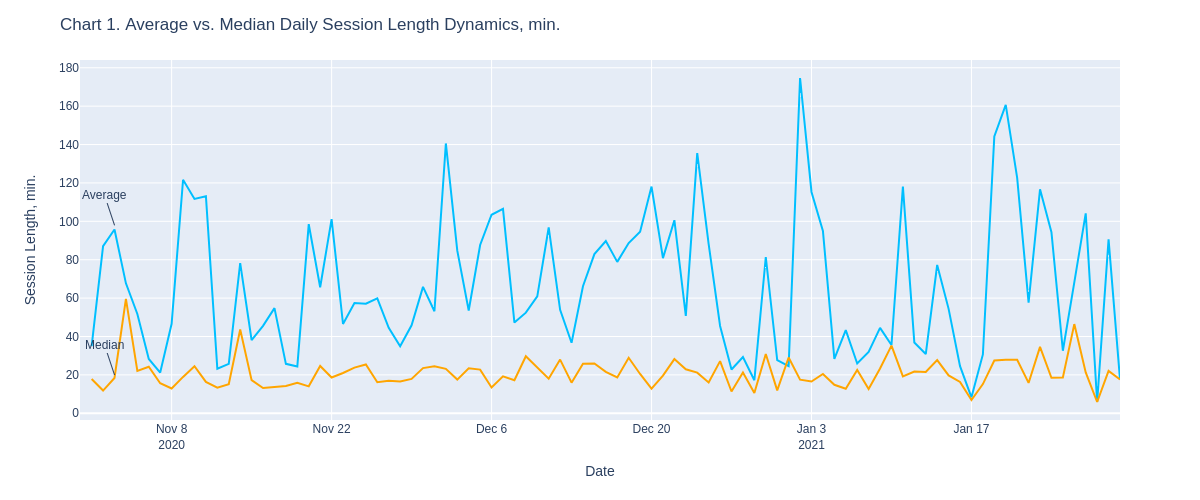

In [32]:
# Median vs Avg session length
fig1 = px.line(df_for_viz, y='avg_session_length', x='event_date', color_discrete_sequence=['deepskyblue'])


median_line = px.line(df_for_viz, y='median_session_length', x='event_date').data[0]
median_line.line.color = 'orange'
fig1.add_trace(median_line)

fig1.add_annotation(x='2020-11-03', y=20, text='Median')
fig1.add_annotation(x='2020-11-03', y=98, text='Average')

fig1.update_layout(title='Chart 1. Average vs. Median Daily Session Length Dynamics, min.',
                  xaxis_title='Date',  # Set x-axis title
                  yaxis_title='Session Length, min.', # Set y-axis title
                  height=500, width=1200)

fig1.show(renderer="png")

Chart 1 shows significant diference in average and median session length. Average likely being affected by small amount of users spending much longer time to make the purchase, thus, skewing the session length distribution.
Therefore, median session time will be used in further analysis.

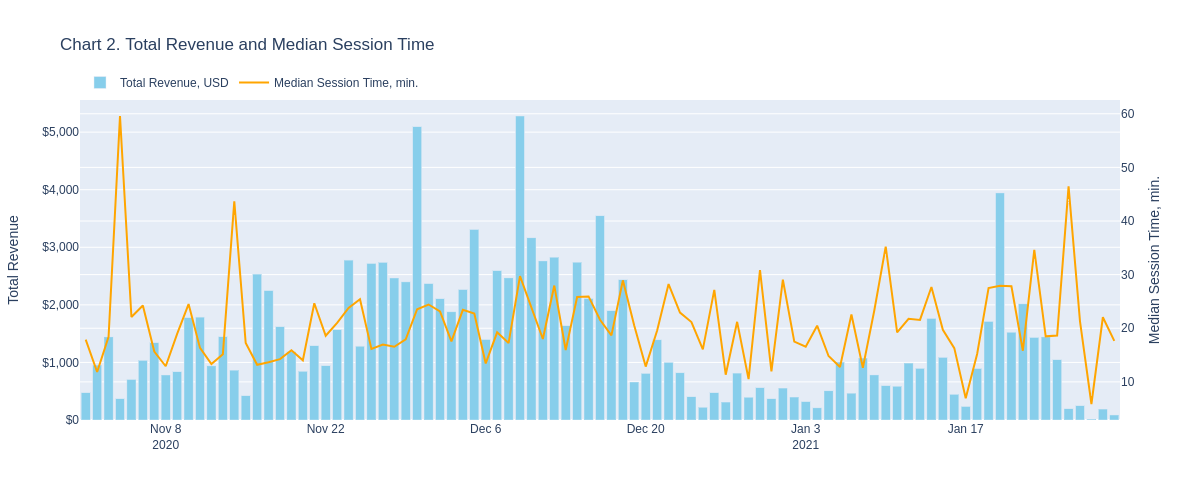

In [31]:
# Create traces for chart with 2 y axis
bar_trace = go.Bar(x=df_for_viz['event_date'], y=df_for_viz['total_revenue'], name='Total Revenue, USD', marker=dict(color='skyblue'))
scatter_trace = go.Scatter(x=df_for_viz['event_date'], y=df_for_viz['median_session_length'], mode='lines', name='Median Session Time, min.', yaxis='y2',line=dict(color='orange'))

layout = go.Layout(title='Chart 2. Total Revenue and Median Session Time',
                   yaxis=dict(title='Total Revenue'),
                   yaxis2=dict(title='Median Session Time, min.', overlaying='y', side='right'),
                   yaxis_tickformat='$,.0f',
                   legend=dict(x=0, y=1.1, traceorder='normal', orientation='h'),
                   height=500, width=1200)

fig2 = go.Figure(data=[bar_trace, scatter_trace], layout=layout)

fig2.show(renderer="png")

The provided data indicates that there isn't a significant correlation between sales revenue and the amount of time users spend on the webpage before making a purchase. Therefore, we cannot definitively conclude that a longer duration spent on the webpage corresponds to a higher likelihood of increased spending.

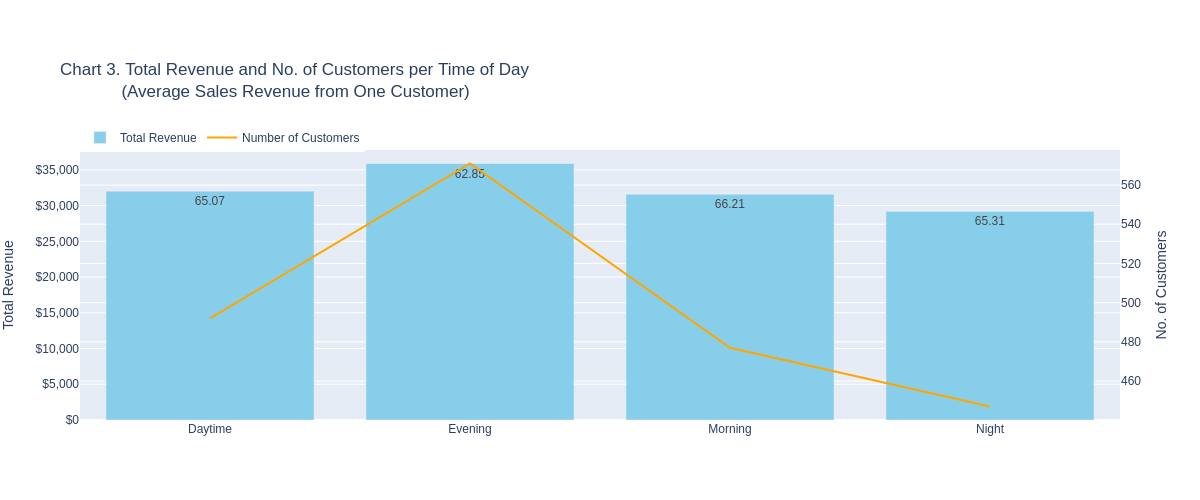

In [30]:
# Create chart for time_of_day vs revenue_per_min
bars = go.Bar(x=df_time_of_day['time_of_day'], y=df_time_of_day['sales_revenue'], name='Total Revenue', marker=dict(color='skyblue'),text=df_time_of_day['average_sales'])
scatter = go.Scatter(x=df_time_of_day['time_of_day'], y=df_time_of_day['num_customers_bought'], mode='lines', name='Number of Customers', yaxis='y2',line=dict(color='orange'))

layout = go.Layout(title='Chart 3. Total Revenue and No. of Customers per Time of Day<br>             (Average Sales Revenue from One Customer)',
                   yaxis=dict(title='Total Revenue'),
                   yaxis2=dict(title='No. of Customers', overlaying='y', side='right'),
                   yaxis_tickformat='$,.0f',
                   legend=dict(x=0, y=1.1, traceorder='normal', orientation='h'),
                   margin=dict(t=150),
                   height=500, width=1200)

fig_time_of_day = go.Figure(data=[bars, scatter], layout=layout)

fig_time_of_day.show(renderer="png")

The evening hours (6 PM to midnight) mark the peak period for traffic on the company's webpage, resulting in the highest sales revenue. Surprisingly, despite this peak, analysis reveals that customers tend to spend the least on average during these evening hours. In contrast, morning users exhibit the highest average spending per customer.

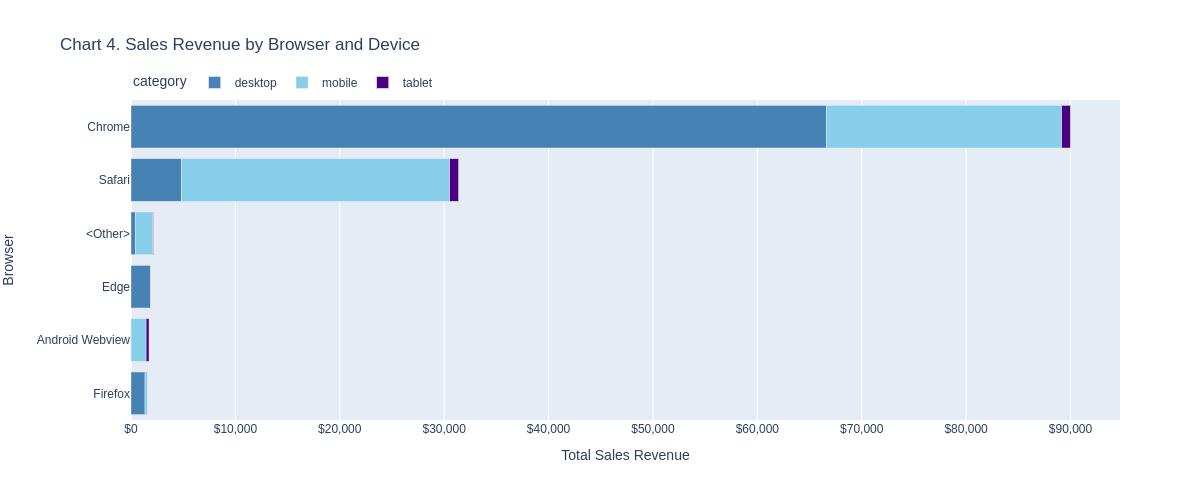

In [33]:
# Create a stacked bar chart to explore which device category and browser are used in making most purchases
browser_bar = px.bar(browser_df, y='browser', x='total_revenue', orientation='h', color='category', color_discrete_map={'desktop': 'steelblue', 'mobile': 'skyblue', 'tablet': 'indigo'})

browser_bar.update_layout(title='Chart 4. Sales Revenue by Browser and Device',
                          xaxis_title='Total Sales Revenue',
                          yaxis_title='Browser',
                          xaxis_tickformat='$,.0f',
                          yaxis={'categoryorder': 'total ascending'},
                          legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='left', x=0),
                          margin=dict(t=100),
                          height=500, width=1200)

browser_bar.show(renderer="png")


The overwhelming majority of revenue is generated by users who utilize the Chrome browser, with Safari coming in as a distant second.

Desktop users represent the primary revenue stream for the business. Specifically, revenue from desktop Chrome users alone is comparable to the combined sales revenue from all other browsers and devices.

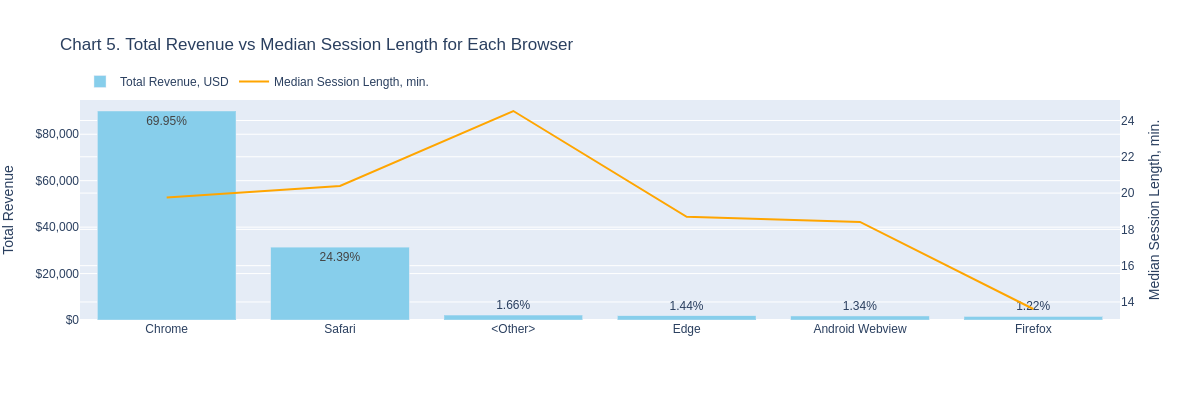

In [34]:
# Sort the DataFrame by 'total_revenue' column
browser_df2_sorted = browser_df2.sort_values(by='total_revenue', ascending=False)

bar_trace3 = go.Bar(x=browser_df2_sorted['browser'], y=browser_df2_sorted['total_revenue'], name='Total Revenue, USD', marker=dict(color='skyblue'), text=browser_df2_sorted['perc_of_revenue'])
scatter_trace3 = go.Scatter(x=browser_df2_sorted['browser'], y=browser_df2_sorted['median_session_length'], mode='lines', name='Median Session Length, min.', yaxis='y2',line=dict(color='orange'))

layout_browser_chart3 = go.Layout(title='Chart 5. Total Revenue vs Median Session Length for Each Browser',
                   yaxis=dict(title='Total Revenue'),
                   yaxis2=dict(title='Median Session Length, min.', overlaying='y', side='right'),
                   yaxis_tickformat='$,.0f',
                   legend=dict(x=0, y=1.15, traceorder='normal', orientation='h'),
                   height=400, width=1200)

fig5 = go.Figure(data=[bar_trace3, scatter_trace3], layout=layout_browser_chart3)

fig5.show(renderer="png")


Both Chrome and Safari users typically take around 20 minutes to complete a purchase. Firefox users exhibit the quickest decision-making process, with a median time before purchase just exceeding 13.5 minutes. However, it's worth noting that there are fewer users utilizing Firefox compared to other browsers. On the other hand, users employing Other browsers take the longest time to make a purchase.

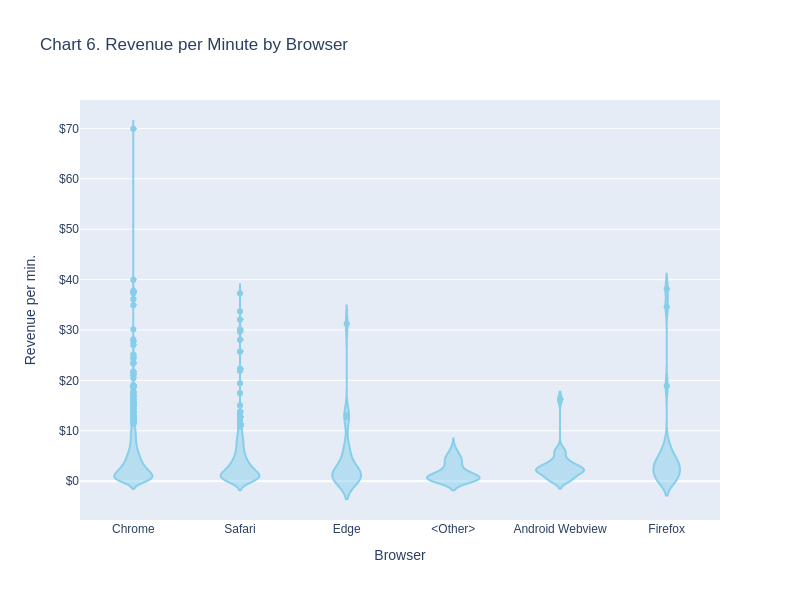

In [35]:
violin_fig = px.violin(merged_df, y='revenue_per_min', x='browser', color_discrete_sequence=['skyblue'], title='Chart 6. Revenue per Minute by Browser')

violin_fig.update_layout(yaxis_tickformat='$,.0f', height=600, width=800)
violin_fig.update_xaxes(title_text='Browser')
violin_fig.update_yaxes(title_text='Revenue per min.')

violin_fig.show(renderer="png")

Chrome and Safari users typically spend up to 11 USD per minute (violin upper fence). Users of other browsers tend to spend up to 6-8 USD per minute.

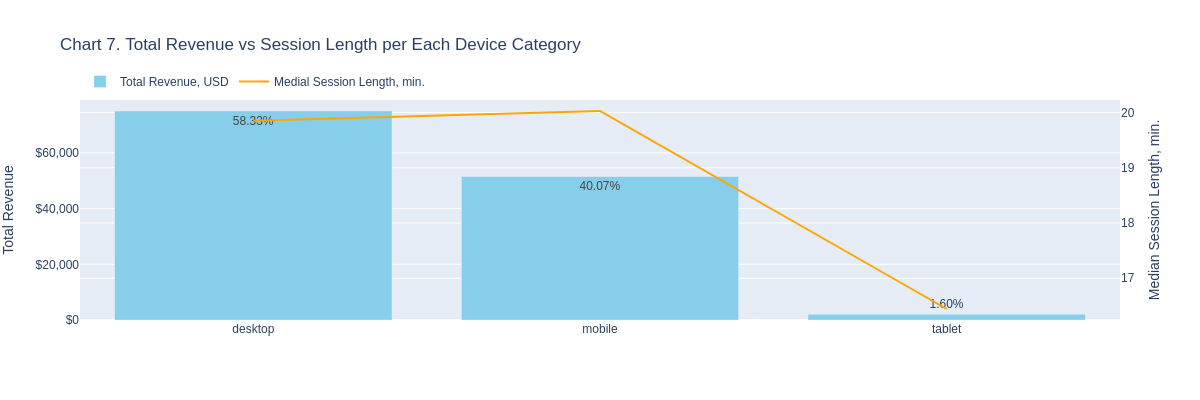

In [36]:
bar_trace4 = go.Bar(x=device_df['category'], y=device_df['total_revenue'], name='Total Revenue, USD', marker=dict(color='skyblue'), text=device_df['perc_of_revenue'])
scatter_trace4 = go.Scatter(x=device_df['category'], y=device_df['median_session_length'], mode='lines', name='Medial Session Length, min.', yaxis='y2',line=dict(color='orange'))

layout_device_chart = go.Layout(title='Chart 7. Total Revenue vs Session Length per Each Device Category',
                   yaxis=dict(title='Total Revenue'),
                   yaxis2=dict(title='Median Session Length, min.', overlaying='y', side='right'),
                   yaxis_tickformat='$,.0f',
                   legend=dict(x=0, y=1.15, traceorder='normal', orientation='h'),
                   height=400, width=1200)

fig6 = go.Figure(data=[bar_trace4, scatter_trace4], layout=layout_device_chart)

fig6.show(renderer="png")

Both mobile and desktop users tend to spend approximately the same amount of time completing a purchase, averaging around 20 minutes. Interestingly, tablet users make purchases much more swiftly. However, despite their quicker purchasing process, sales revenue from tablet purchases only accounts for 1.6% of the total overall sales.

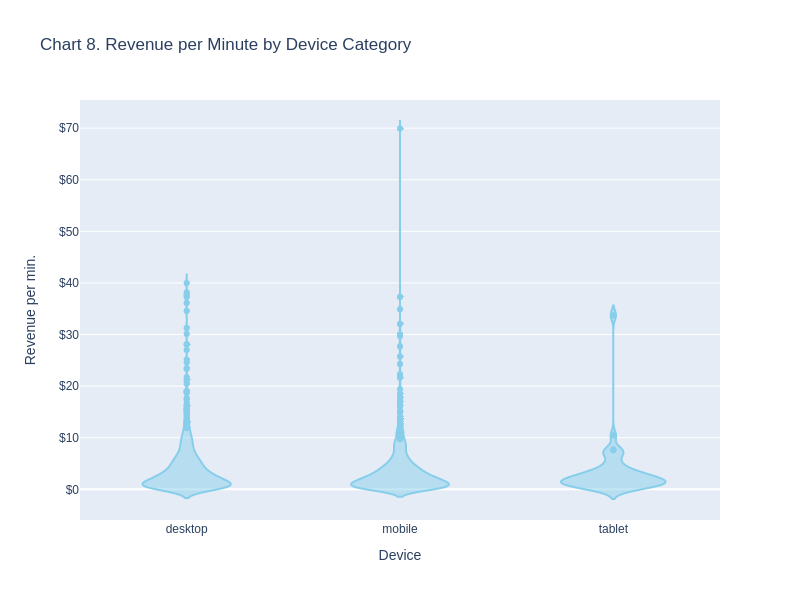

In [37]:
violin_fig2 = px.violin(merged_df, y='revenue_per_min', x='category', color_discrete_sequence=['skyblue'], title='Chart 8. Revenue per Minute by Device Category')

violin_fig2.update_layout(yaxis_tickformat='$,.0f', height=600, width=800)
violin_fig2.update_xaxes(title_text='Device')
violin_fig2.update_yaxes(title_text='Revenue per min.')

violin_fig2.show(renderer="png")

As previously mentioned, over fifty percent of the sales revenue originates from desktop users, in part because they demonstrate a higher propensity to spend. This observation is corroborated by the violin chart, indicating that desktop users are inclined to spend up to 12 USD per minute (violin upper fence), whereas mobile and tablet users typically spend up to 10 USD and 7 USD respectively.

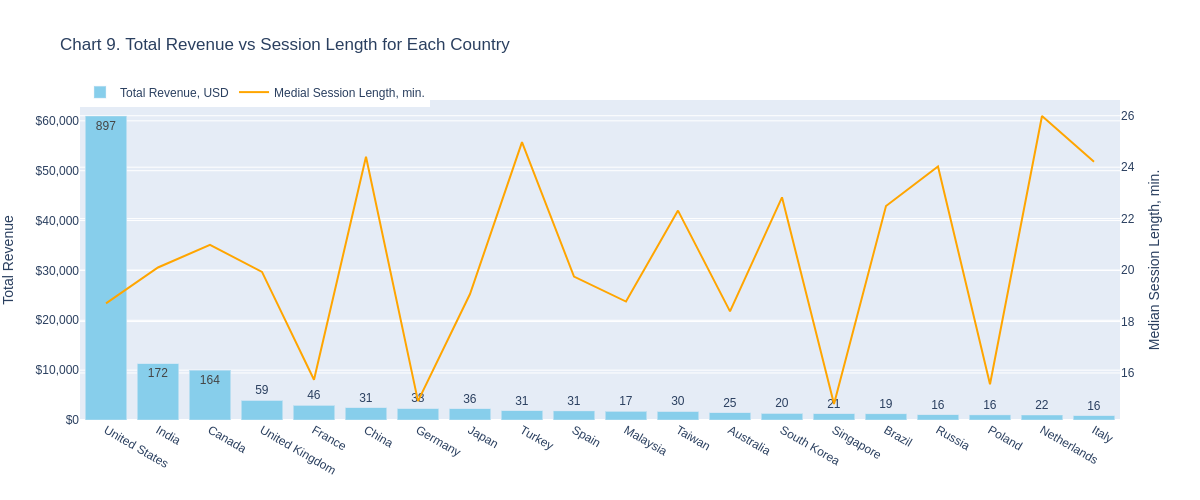

In [40]:
# Sort the DataFrame by 'total_revenue' column
country_df_sorted = country_df.sort_values(by='total_revenue', ascending=False)

# Take only top 20 countries for easier analysis
counry_top20 = country_df_sorted.head(20)

bar_trace5 = go.Bar(x=counry_top20['country'], y=counry_top20['total_revenue'], name='Total Revenue, USD', marker=dict(color='skyblue'), text=counry_top20['num_customers_bought'])
scatter_trace5 = go.Scatter(x=counry_top20['country'], y=counry_top20['median_session_length'], mode='lines', name='Medial Session Length, min.', yaxis='y2',line=dict(color='orange'))

layout_country_chart = go.Layout(title='Chart 9. Total Revenue vs Session Length for Each Country',
                   yaxis=dict(title='Total Revenue'),
                   yaxis2=dict(title='Median Session Length, min.', overlaying='y', side='right'),
                   yaxis_tickformat='$,.0f',
                   legend=dict(x=0, y=1.07, traceorder='normal', orientation='h'),
                   height=500, width=1200)

fig7 = go.Figure(data=[bar_trace5, scatter_trace5], layout=layout_country_chart)

fig7.show(renderer="png")

The United States dominates as the largest market in both user count and sales revenue, followed by India and Canada at a considerable distance. In terms of purchasing time, users in the US typically take 18 minutes to complete a purchase, while in India and Canada, the average times are 20 and 21 minutes, respectively.

Among the top 20 markets, China, Turkey, and the Netherlands have the longest purchasing times, while France, Germany, Poland, and Singapore have the shortest. The disparity between the shortest and longest purchasing times is approximately 10 minutes.

# To sum up:

**Data:** Website event data for November 1st, 2020 to January 30th, 2021.

**Users of interest:** People who made a purchase on the same day as visiting the webpage for the first time.

**Goals:** Finding out, whether there is a connection between the time spent on the webpage and sales volume.
Finding out what other factors may be connected to longer session times.

- The given data does not show close connection between the sales revenue and time that the users spent on the webpage before making a purchase (Chart 2.). Thus, we may not conclude that the shorter/longer the user spends on the webpage, the more he/she is likely to spend.

- Evening (6 PM to midnight) is the time of the day that the company's webpage gets the most traffic and the company makes the highest sales revenue. However, calculating the average one customer spending we see that evening customers spend the least on average. The customers spending the most on average are morning users (Chart 3).

- The absolute majority of revenue comes from users who use Chrome browser. Distant second being Safari (Chart 4.).

- Desktop users are the main revenue source for the business. Desktop Chrome users alone bring similar sales revenue to the company as all other browsers and devices combined (Chart 4.).

- Firefox users are the fastest to decide to buy, with median time before purchase just over 13.5 minutes. There are the fewest users using Firefox, though.
Users taking the longest to purchase are users using Other browsers.
Both Chrome and Safari users taking ~20 min. to buy a product (Chart 5).

- Chrome and Safari users tend to spend up to 11 USD per minute, while the users of other browsers spend 6-8 USD per session minute. (Chart 6.).

- Mobile and Desktop users take very similar amount of time to purchase (~20 min.), while tablet users purchase much faster, yet, the overall sales revenue from purchases made by tablet is only 1.6% of overall sales (Chart 7.).

- As discussed, more than half of sales revenue comes from desktop users, in part due to the desktop users being more willing to spend more. The violin chart shows that desktop users are more likely to spend up to 12 USD per minute (violin upper fence), while mobile users spend up to 10 USD, tablet up to 7 USD (Chart 8).

- US is the biggest market both in terms of user count and sales revenue. With India and Canada being distant second and third. With users spending 18 minutes to buy in the US and 20 and 21 minutes in India and Canada respectively (Chart 9.).

- Out of top 20 markets, China, Turkey and the Netherlands have the longest times to purchase. France, Germany, Poland and Singapore - the shortest. The difference between shortest and longest times being ~10 min.

# Suggestions

1. Session length does not play a major role in terms of how much the person may spend. Reviewing the way the purchase time is measured might be a good idea. The company operates all over the world, thus, time zones may affect purchases' measuring in terms of them being made the same day as the first visit. The company may want to consider determining a certain amount of time till the user was active to consider the session ended and not the certain date.

2. A/B testing may be introduced to test whether a different "Call to action" methods may let the customers find their way through the funnel easier.

3. Evening is the most popular time of the day to visit the webpage, however, bigger sales are done in the morning. The company may A/B test versions of the webpage emphasising the pricier items in the morning, as the customers may be less sensitive to price then.

4. 70% of revenue comes from Chrome browser, 74% of which from Desktop version. It is important the team works to ensure Chrome desktop version is up to date and the users are easily navigated through the sales funnel.

5. Mobile version of the webpage is important to both Chrome and Safari users. Making and maintaining the mobile webpage version for both Chrome and Safari is essential.

6. It is important to test the versions used in China, Turkey, the Netherlands and make sure they are running and easy to understand and navigate.

